In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import os, glob
import pandas as pd

device = torch.device('cuda:3')

In [2]:
df = pd.read_csv("fifa_pose_keypoints_raw.csv")
df = df.reset_index(drop=True)

In [3]:
len(df)

3562

In [4]:
class PoseHeightDataset(Dataset):
    def __init__(self, df):
        kp_cols = [f"kp{i}" for i in range(51)]
        X_raw = df[kp_cols].values.reshape(-1, 17, 3)
        X_xy = X_raw[:, :, :2]
        self.X = (X_xy.reshape(len(df), -1) / 256.0).astype(np.float32)
        self.X = np.clip(self.X, 0, 1)
        
        self.y = df["height_cm"].values.astype(np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

In [5]:
class HeightRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(34, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

In [6]:
df_labeled = pd.read_csv("fifa_pose_keypoints_3class.csv")
df_labeled = df_labeled[df_labeled["new_label"] == "full_body"]
data_size = len(df_labeled)

df = df.sample(data_size)
dataset = PoseHeightDataset(df)

In [7]:
train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

In [8]:
model = HeightRegressor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

In [9]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)

    return total_loss / len(loader.dataset)

In [10]:
def evaluate(model, loader):
    model.eval()
    mae = 0

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            mae += torch.abs(pred - y).sum().item()

    return mae / len(loader.dataset)

In [11]:
best_mae = float("inf")

for epoch in range(1, 31):
    train_loss = train_epoch(model, train_loader)
    val_mae = evaluate(model, val_loader)

    if val_mae < best_mae:
        best_mae = val_mae
        torch.save(model.state_dict(), "height_regressor_baseline_best.pt")

    print(
        f"epoch {epoch:03d}  "
        f"train mse {train_loss:.2f}  "
        f"val mae {val_mae:.2f} cm  "
    )

epoch 001  train mse 33038.20  val mae 180.08 cm  
epoch 002  train mse 32893.07  val mae 179.61 cm  
epoch 003  train mse 32673.32  val mae 178.78 cm  
epoch 004  train mse 32306.29  val mae 177.34 cm  
epoch 005  train mse 31664.33  val mae 175.01 cm  
epoch 006  train mse 30678.71  val mae 171.47 cm  
epoch 007  train mse 29277.20  val mae 166.34 cm  
epoch 008  train mse 27200.24  val mae 159.20 cm  
epoch 009  train mse 24735.20  val mae 149.64 cm  
epoch 010  train mse 21393.71  val mae 137.27 cm  
epoch 011  train mse 17633.04  val mae 121.90 cm  
epoch 012  train mse 13599.39  val mae 103.56 cm  
epoch 013  train mse 9469.41  val mae 82.68 cm  
epoch 014  train mse 6030.83  val mae 60.43 cm  
epoch 015  train mse 3415.60  val mae 39.43 cm  
epoch 016  train mse 1713.62  val mae 24.61 cm  
epoch 017  train mse 1036.50  val mae 19.31 cm  
epoch 018  train mse 922.77  val mae 19.46 cm  
epoch 019  train mse 946.55  val mae 19.35 cm  
epoch 020  train mse 822.09  val mae 19.11 cm  

In [12]:
model = HeightRegressor().to(device)
model.load_state_dict(torch.load("height_regressor_baseline_best.pt"))
model.eval()

val_mae = evaluate(model, val_loader)
print(f"final validation mae: {val_mae:.2f} cm")

final validation mae: 18.80 cm


/tmp/ipykernel_157285/981767053.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("height_regressor_baseline_best.pt"))


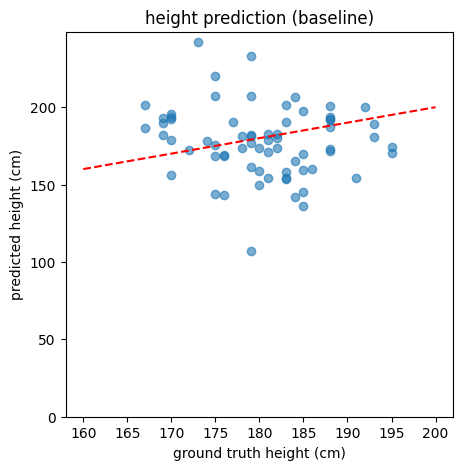

In [13]:
import matplotlib.pyplot as plt

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X, y in val_loader:
        X = X.to(device)
        pred = model(X).cpu().numpy()
        y_pred.extend(pred)
        y_true.extend(y.numpy())

plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([160, 200], [160, 200], 'r--')
plt.xlabel("ground truth height (cm)")
plt.ylabel("predicted height (cm)")
plt.title("height prediction (baseline)")

plt.ylim(bottom=0) 
plt.show()